In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-10-24 09:23:46.562198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 09:23:47.179667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-24 09:23:47.781018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-24 09:23:47.817035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Maranhão - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [7]:
data = pd.read_csv('2003_mo_model_input_MA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Maranhão - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,43.342,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,28.663,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,27.900,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,25.739,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,30.203,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


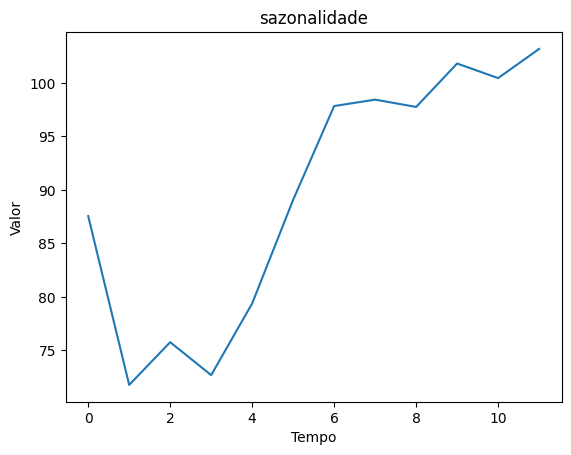

,sazonalidade
sazonalidade,
0,87.556270
1,71.779152
2,75.772632
3,72.694577
4,79.392843
5,89.079325
6,97.841374
7,98.441639
8,97.756470


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade,sazonalidade,Maranhão - Consumo de Cimento (t)
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204,87.556270,43.342
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513,71.779152,28.663
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821,75.772632,27.900
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129,72.694577,25.739
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438,79.392843,30.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.392843,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.079325,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.841374,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.441639,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      42.076
1      30.183
2      40.701
3      39.783
4      38.903
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Maranhão - Consumo de Cimento (t), Length: 249, dtype: float64

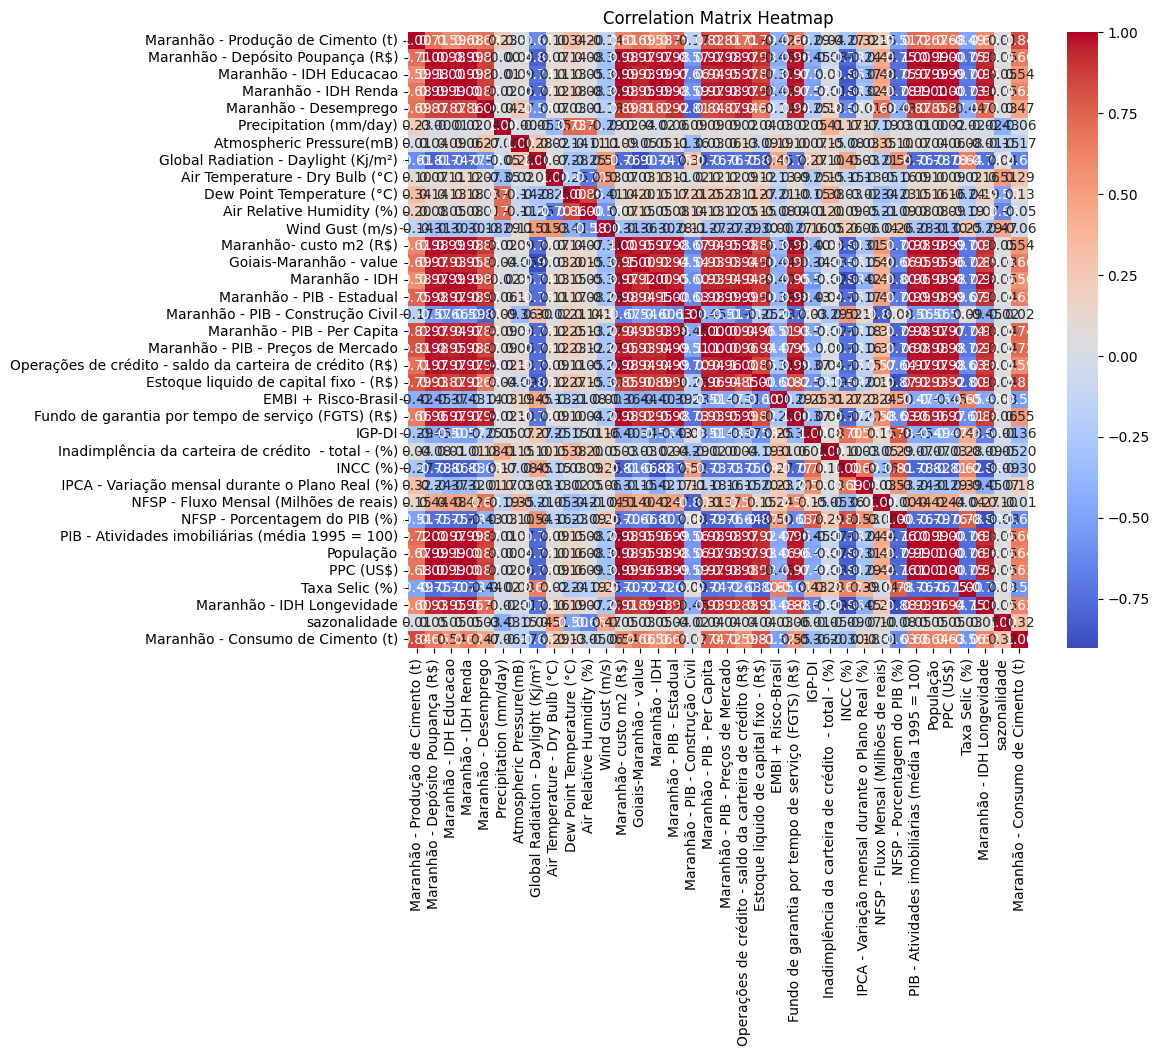

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Maranhão - Produção de Cimento (t),2.264242e+04
1,Maranhão - Depósito Poupança (R$),1.658318e+05
2,Maranhão - IDH Educacao,5.684791e+06
3,Maranhão - IDH Renda,1.119444e+08
4,Maranhão - Desemprego,5.365215e+04
5,Precipitation (mm/day),9.347369e+01
6,Atmospheric Pressure(mB),5.781432e+06
7,Global Radiation - Daylight (Kj/m²),1.307866e+02
8,Air Temperature - Dry Bulb (°C),5.266755e+05
9,Dew Point Temperature (°C),3.457200e+05


In [14]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,4.315322e+07,2.636001e+06,6.034057,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,87.556270
1,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,4.320832e+07,2.636851e+06,6.036083,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,71.779152
2,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,4.326343e+07,2.637701e+06,6.038110,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,75.772632
3,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,4.331853e+07,2.638551e+06,6.040136,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,72.694577
4,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,4.337364e+07,2.639401e+06,6.042163,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,79.392843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,31.437669,5.318247e+06,0.690696,0.605758,12.252094,2.262652,1006.018935,1370.197401,26.902086,22.707143,78.794074,2.114620,25218.309704,0.380169,5.187008e+07,2.573396e+06,6.208819,3.161173e+06,7.751979e+06,267.077474,9.671878e+06,0.616129,3.065096,0.365766,0.295704,2763.919661,2.182490,203.197885,427.801099,0.584520,98.441639
188,31.386187,5.327538e+06,0.690737,0.605684,12.242560,2.255048,1005.635099,1364.345398,26.970262,22.727219,78.568918,2.160323,25328.342274,0.381038,5.183228e+07,2.574824e+06,6.207237,3.175923e+06,7.749126e+06,271.858581,9.603901e+06,0.674037,3.039354,0.385220,0.308341,4007.361038,2.152734,203.697961,428.745380,0.552977,97.756470
189,31.263827,5.336829e+06,0.690778,0.605610,12.233025,1.822532,1005.605537,1347.919933,27.031975,22.901460,79.065898,2.135453,25439.050428,0.381915,5.179448e+07,2.576252e+06,6.205654,3.198368e+06,7.746272e+06,274.512833,1.017487e+07,0.717754,2.996890,0.415153,0.314175,4174.914508,2.107975,204.198036,429.625387,0.499108,101.815109
190,30.867238,5.346121e+06,0.690819,0.605537,12.223491,1.820290,1005.572233,1311.383402,26.930710,23.145969,80.660051,2.021685,25548.086528,0.383209,5.175668e+07,2.577681e+06,6.204072,3.217793e+06,7.743419e+06,274.927477,1.089344e+07,0.772352,2.963249,0.434114,0.321299,5007.894546,2.054724,204.534773,430.429701,0.557854,100

In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.747691,-1.898398,-1.999122,-0.822290,-0.196619,0.282587,0.022205,0.105918,-0.712248,-0.605630,0.694542,-1.631198,-0.950106,-1.681167,-0.279527,-2.120335,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-1.825286,2.132459
1,-1.739862,-1.873011,-1.971892,-0.825118,-0.195619,0.280378,0.022205,0.105782,-0.707680,-0.602083,0.691473,-1.608628,-0.970613,-1.663459,-0.262506,-2.086804,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-1.813648,1.592202
2,-1.732033,-1.847625,-1.944662,-0.827947,-0.195036,0.279090,0.022205,0.105703,-0.705016,-0.600014,0.689683,-1.588255,-0.999751,-1.645750,-0.245485,-2.053272,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.801637,2.999926
3,-1.724205,-1.822239,-1.917432,-0.830775,-0.194974,0.278952,0.022205,0.105695,-0.704731,-0.599792,0.689491,-1.569374,-1.025491,-1.628041,-0.228464,-2.019741,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.789347,1.273293
4,-1.716376,-1.796852,-1.890202,-0.833603,-0.076690,-0.024928,0.126049,-0.254260,-0.564552,-0.305679,0.549717,-1.551415,-1.058403,-1.610333,-0.211443,-1.986210,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.777381,2.045407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.325769,1.470193,1.231383,1.189788,-0.316867,0.709498,-0.638954,-0.123881,-1.053413,-0.732207,0.147024,1.721209,1.221276,1.120107,-1.533048,0.771361,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.413217,-1.311366
188,1.333470,1.472011,1.227600,1.185037,-0.330364,0.244198,-0.639832,0.044005,-1.019700,-0.793344,0.234950,1.746354,1.236987,1.107960,-1.504452,0.745175,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.425045,-1.417143
189,1.341170,1.473829,1.223817,1.180287,-1.098117,0.208362,-0.642297,0.195979,-0.727103,-0.658398,0.187104,1.771653,1.252847,1.095812,-1.475855,0.718990,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.436067,-1.597784
190,1.348871,1.475647,1.220034,1.175536,-1.102097,0.167990,-0.647779,-0.053393,-0.316506,-0.225535,-0.031774,1.796570,1.276241,1.083664,-1.447259,0.692804,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.446142,-1.400787


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.747691,-1.898398,-1.999122,-0.822290,-0.196619,0.282587,0.022205,0.105918,-0.712248,-0.605630,0.694542,-1.631198,-0.950106,-1.681167,-0.279527,-2.120335,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-1.825286,2.132459
1,-1.739862,-1.873011,-1.971892,-0.825118,-0.195619,0.280378,0.022205,0.105782,-0.707680,-0.602083,0.691473,-1.608628,-0.970613,-1.663459,-0.262506,-2.086804,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-1.813648,1.592202
2,-1.732033,-1.847625,-1.944662,-0.827947,-0.195036,0.279090,0.022205,0.105703,-0.705016,-0.600014,0.689683,-1.588255,-0.999751,-1.645750,-0.245485,-2.053272,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.801637,2.999926
3,-1.724205,-1.822239,-1.917432,-0.830775,-0.194974,0.278952,0.022205,0.105695,-0.704731,-0.599792,0.689491,-1.569374,-1.025491,-1.628041,-0.228464,-2.019741,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.789347,1.273293
4,-1.716376,-1.796852,-1.890202,-0.833603,-0.076690,-0.024928,0.126049,-0.254260,-0.564552,-0.305679,0.549717,-1.551415,-1.058403,-1.610333,-0.211443,-1.986210,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.777381,2.045407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.926284,1.376582,1.318724,1.431469,0.495217,0.243276,-0.661819,0.803324,1.080537,0.420152,-0.443237,1.066587,0.944351,1.197811,-1.616416,0.972153,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.044043,0.043807
158,0.942030,1.381781,1.316585,1.418921,0.982093,0.704668,-0.664315,0.571787,1.226316,0.656928,-0.746910,1.087443,0.952621,1.200726,-1.633804,0.973222,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.056960,0.210856
159,0.957777,1.386980,1.314446,1.406373,0.693908,1.024101,-0.660073,0.415711,1.115871,0.656928,-0.882676,1.106646,0.960982,1.203641,-1.651193,0.974290,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.070172,0.107070
160,0.973523,1.392179,1.312307,1.393825,0.812950,1.570300,-0.655535,0.274636,0.737157,0.436286,-0.784425,1.126586,0.969363,1.206556,-1.668581,0.975359,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.083626,0.392942


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      42.076
1      30.183
2      40.701
3      39.783
4      38.903
        ...  
157    66.661
158    78.801
159    67.256
160    84.280
161    86.501
Name: Maranhão - Consumo de Cimento (t), Length: 162, dtype: float64

In [18]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
126,0.823864,0.451576,0.692410,0.858960,-0.542428,0.686896,-0.630242,-0.200400,-0.448745,-0.097398,-0.191176,0.511084,0.673675,0.831326,0.271134,1.034804,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.697312,-1.048761
127,0.848442,0.460075,0.690103,0.892045,-0.938409,0.113657,-0.622498,0.411160,-0.881025,-0.786733,0.338303,0.525601,0.687412,0.850067,0.230720,1.041385,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.706933,-0.649312
128,0.873020,0.468574,0.687796,0.925130,-0.458288,-0.243074,-0.618407,0.755606,-1.273702,-1.280776,0.711827,0.541430,0.706891,0.868808,0.190305,1.047966,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.715675,-0.535369
129,0.897599,0.477073,0.685489,0.958215,-0.735620,-0.500551,-0.626137,0.570431,-1.395846,-1.300155,0.704428,0.556528,0.722784,0.887549,0.149891,1.054547,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.723490,-1.288807
130,0.922177,0.485572,0.683182,0.991300,-0.543447,-0.862060,-0.636342,0.209520,-1.181683,-0.974891,0.415826,0.571364,0.738712,0.906289,0.109477,1.061127,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.730579,-1.507550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.325769,1.470193,1.231383,1.189788,-0.316867,0.709498,-0.638954,-0.123881,-1.053413,-0.732207,0.147024,1.721209,1.221276,1.120107,-1.533048,0.771361,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.413217,-1.311366
188,1.333470,1.472011,1.227600,1.185037,-0.330364,0.244198,-0.639832,0.044005,-1.019700,-0.793344,0.234950,1.746354,1.236987,1.107960,-1.504452,0.745175,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.425045,-1.417143
189,1.341170,1.473829,1.223817,1.180287,-1.098117,0.208362,-0.642297,0.195979,-0.727103,-0.658398,0.187104,1.771653,1.252847,1.095812,-1.475855,0.718990,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.436067,-1.597784
190,1.348871,1.475647,1.220034,1.175536,-1.102097,0.167990,-0.647779,-0.053393,-0.316506,-0.225535,-0.031774,1.796570,1.276241,1.083664,-1.447259,0.692804,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.446142,-1.400787


In [19]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [20]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 29)

In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 29)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [50]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=10)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(180, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', 
                             return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [51]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][10:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [52]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1068159412, 2695128025, 2032730129, 4182079639, 3674584555, 472660718, 911428425, 3759981374, 690871587, 1846445841]


Step: 0 ___________________________________________
val_loss: 217.37852478027344
winner_seed: 1068159412


Step: 1 ___________________________________________
val_loss: 211.5370330810547
winner_seed: 2695128025


Step: 2 ___________________________________________
val_loss: 752.6889038085938


Step: 3 ___________________________________________
val_loss: 208.59776306152344
winner_seed: 4182079639


Step: 4 ___________________________________________
val_loss: 797.7985229492188


Step: 5 ___________________________________________
val_loss: 209.474853515625


Step: 6 ___________________________________________
val_loss: 223.50149536132812


Step: 7 ___________________________________________
val_loss: 792.2538452148438


Step: 8 ___________________________________________
val_loss: 218.07095336914062


Step: 9 ___________________________________________
val_loss: 234.3

In [53]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 394904081

Epoch 1/10000
4/4 [==============================] - 2s 139ms/step - loss: 12057.2607 - val_loss: 8681.1631
Epoch 2/10000
4/4 [==============================] - 0s 14ms/step - loss: 11076.8643 - val_loss: 7302.5757
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 10139.2412 - val_loss: 6471.6172
Epoch 4/10000
4/4 [==============================] - 0s 15ms/step - loss: 9512.1562 - val_loss: 6071.7935
Epoch 5/10000
4/4 [==============================] - 0s 15ms/step - loss: 9134.1084 - val_loss: 5851.9688
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 8900.4600 - val_loss: 5702.5356
Epoch 7/10000
4/4 [==============================] - 0s 15ms/step - loss: 8731.1494 - val_loss: 5575.8535
Epoch 8/10000
4/4 [==============================] - 0s 14ms/step - loss: 8583.3682 - val_loss: 5455.9639
Epoch 9/10000
4/4 [==============================] - 0s 15ms/step - loss: 8438.3447 - val_loss: 5340.8916
Epoch 10/10000
4/4 [======================

4/4 [==============================] - 0s 14ms/step - loss: 2881.4888 - val_loss: 1131.0994
Epoch 78/10000
4/4 [==============================] - 0s 16ms/step - loss: 2837.4897 - val_loss: 1101.1488
Epoch 79/10000
4/4 [==============================] - 0s 15ms/step - loss: 2790.9424 - val_loss: 1072.1251
Epoch 80/10000
4/4 [==============================] - 0s 16ms/step - loss: 2746.8389 - val_loss: 1043.3556
Epoch 81/10000
4/4 [==============================] - 0s 15ms/step - loss: 2703.7712 - val_loss: 1014.9874
Epoch 82/10000
4/4 [==============================] - 0s 15ms/step - loss: 2662.0994 - val_loss: 987.1917
Epoch 83/10000
4/4 [==============================] - 0s 14ms/step - loss: 2617.3828 - val_loss: 960.8343
Epoch 84/10000
4/4 [==============================] - 0s 14ms/step - loss: 2577.0598 - val_loss: 934.8615
Epoch 85/10000
4/4 [==============================] - 0s 15ms/step - loss: 2536.8662 - val_loss: 909.5403
Epoch 86/10000
4/4 [==============================] - 0s

Epoch 154/10000
4/4 [==============================] - 0s 16ms/step - loss: 1040.8046 - val_loss: 210.9756
Epoch 155/10000
4/4 [==============================] - 0s 15ms/step - loss: 1032.8505 - val_loss: 210.2747
Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 1024.0392 - val_loss: 209.7137
Epoch 157/10000
4/4 [==============================] - 0s 12ms/step - loss: 1016.7444 - val_loss: 209.2567
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 1008.8251 - val_loss: 208.9259
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 1000.6904 - val_loss: 208.7104
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 993.3385 - val_loss: 208.6009
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 986.2908 - val_loss: 208.5978
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 979.0149 - val_loss: 208.6951
Epoch 163/10000
4/4 [===================

Epoch 231/10000
4/4 [==============================] - 0s 14ms/step - loss: 489.4674 - val_loss: 475.6826
Epoch 232/10000
4/4 [==============================] - 0s 15ms/step - loss: 486.8090 - val_loss: 484.1402
Epoch 233/10000
4/4 [==============================] - 0s 15ms/step - loss: 481.2906 - val_loss: 489.7764
Epoch 234/10000
4/4 [==============================] - 0s 15ms/step - loss: 479.5165 - val_loss: 494.8276
Epoch 235/10000
4/4 [==============================] - 0s 15ms/step - loss: 475.8607 - val_loss: 499.6313
Epoch 236/10000
4/4 [==============================] - 0s 15ms/step - loss: 472.5468 - val_loss: 504.6982
Epoch 237/10000
4/4 [==============================] - 0s 15ms/step - loss: 470.0445 - val_loss: 511.1675
Epoch 238/10000
4/4 [==============================] - 0s 13ms/step - loss: 467.1430 - val_loss: 519.9432
Epoch 239/10000
4/4 [==============================] - 0s 14ms/step - loss: 464.4418 - val_loss: 530.5093
Epoch 240/10000
4/4 [=========================

In [54]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [55]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,91.827354,91.827354,91.827354,91.827354,91.827354,91.827354,91.827354,91.82737,90.951607,-10.541377,-10.535655,-10.517753,-10.467114,-10.471438,-10.457822,-10.450207,-10.454272,-10.453977,-10.489604,-10.535115,-10.535312,-10.552869,-10.540587,-10.512892,-10.476922,-10.448071,-10.416397,-10.416026,-10.421487,-10.423541
Target,88.78,86.195,84.121,88.187,79.514,74.061,64.818,44.254,52.169,53.399,45.364,67.103,61.062,73.445,69.471,83.004,77.332,58.591,70.66,50.796,47.834,45.327,54.032,60.657,67.25,70.773,67.01,81.128,81.737,76.841
Error,3.047356,5.632355,7.706352,3.640358,12.313354,17.766357,27.009354,47.573368,38.782608,63.940376,55.899654,77.62075,71.529114,83.916435,79.928825,93.454208,87.78627,69.044975,81.149605,61.331116,58.369312,55.879868,64.572586,71.169891,77.726921,81.221077,77.426399,91.544022,92.158485,87.264542


In [56]:
display(mae)
display(mape)

58.213528

0.9126854

In [57]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [58]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[793.97565]] - Target[827.965]| =  Error: [[33.98938]]; MAPE:[[0.04105171]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[-125.92121]] - Target[752.2110000000002]| =  Error: [[878.1322]]; MAPE:[[1.1674014]]
1/1 [==============================] - 0s 16ms/step
Ano-5: |Prediction[[-62.602444]] - Target[444.73900000000003]| =  Error: [[507.34146]]; MAPE:[[1.1407622]]


[array([[33.98938]], dtype=float32),
 array([[878.1322]], dtype=float32),
 array([[507.34146]], dtype=float32)]

473.15433

0.7830718